# Check HMASR

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# # For parallelisation
# from dask.distributed import Client
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
# client

In [3]:
# client.close()

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'

In [3]:
ds = xr.open_dataset(path+'HMA_SR_D_v01_N37_0E72_0_agg_16_WY1999_00_SWE_SCA_POST.nc')
ds

<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225, Stats: 5)
Coordinates:
  * Latitude   (Latitude) float32 37.997776 37.993332 ... 37.006737 37.002293
  * Longitude  (Longitude) float32 72.00222 72.00667 ... 72.99411 72.99856
Dimensions without coordinates: Day, Stats
Data variables:
    SWE_Post   (Day, Stats, Longitude, Latitude) float32 ...
    SCA_Post   (Day, Stats, Longitude, Latitude) float32 ...

In [4]:
# Add time coordinates (time starts 1rst october)
ds = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))
swe = ds.SWE_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
scf = ds.SCA_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")

In [5]:
scf.load()

<xarray.DataArray 'SCA_Post' (time: 366, lat: 225, lon: 225)>
array([[[5.260e-02, 2.540e-02, 3.200e-02, ..., 1.066e-01, 1.010e-01,
         8.400e-03],
        [4.560e-02, 5.200e-03, 2.940e-02, ..., 1.104e-01, 8.360e-02,
         7.160e-02],
        [1.600e-03, 1.200e-03, 2.680e-02, ..., 8.280e-02, 5.940e-02,
         5.840e-02],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.100e-02, 1.450e-01,
         1.022e-01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.160e-01, 6.700e-02,
         1.344e-01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.860e-02, 1.460e-02,
         5.280e-02]],

       [[2.360e-02, 1.260e-02, 7.400e-03, ..., 1.106e-01, 1.208e-01,
         7.360e-02],
        [3.040e-02, 1.600e-03, 2.000e-03, ..., 1.370e-01, 9.820e-02,
         8.040e-02],
        [2.880e-02, 0.000e+00, 0.000e+00, ..., 9.100e-02, 8.620e-02,
         6.080e-02],
...
        [8.652e-01, 5.900e-02, 7.880e-02, ..., 7.560e-02, 8.440e-02,
         4.220e-02],
        [7.390e-01, 9.800e-03, 1.940e-02, ..., 9.320e-02, 4.700e-02,
         3.660e-02],
        [8.632e-01, 4.400e-03, 1.920e-02, ..., 3.420e-02, 6.800e-03,
         2.100e-02]],

       [[5.220e-02, 2.440e-02, 2.600e-02, ..., 7.540e-02, 9.360e-02,
         9.900e-02],
        [4.160e-02, 2.600e-02, 6.620e-02, ..., 7.760e-02, 1.076e-01,
         1.230e-01],
        [6.380e-02, 3.220e-02, 1.780e-02, ..., 9.260e-02, 8.300e-02,
         5.580e-02],
        ...,
        [7.932e-01, 5.260e-02, 7.060e-02, ..., 9.060e-02, 8.140e-02,
         6.600e-02],
        [6.774e-01, 8.800e-03, 1.740e-02, ..., 7.740e-02, 6.520e-02,
         6.860e-02],
        [7.912e-01, 4.000e-03, 1.740e-02, ..., 1.084e-01, 6.500e-02,
         4.880e-02]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 37.997776 37.993332 37.988888 ... 37.006737 37.002293
  * lon      (lon) float32 72.00222 72.00667 72.011116 ... 72.99411 72.99856
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2000-09-30
Attributes:
    Units:    [-]

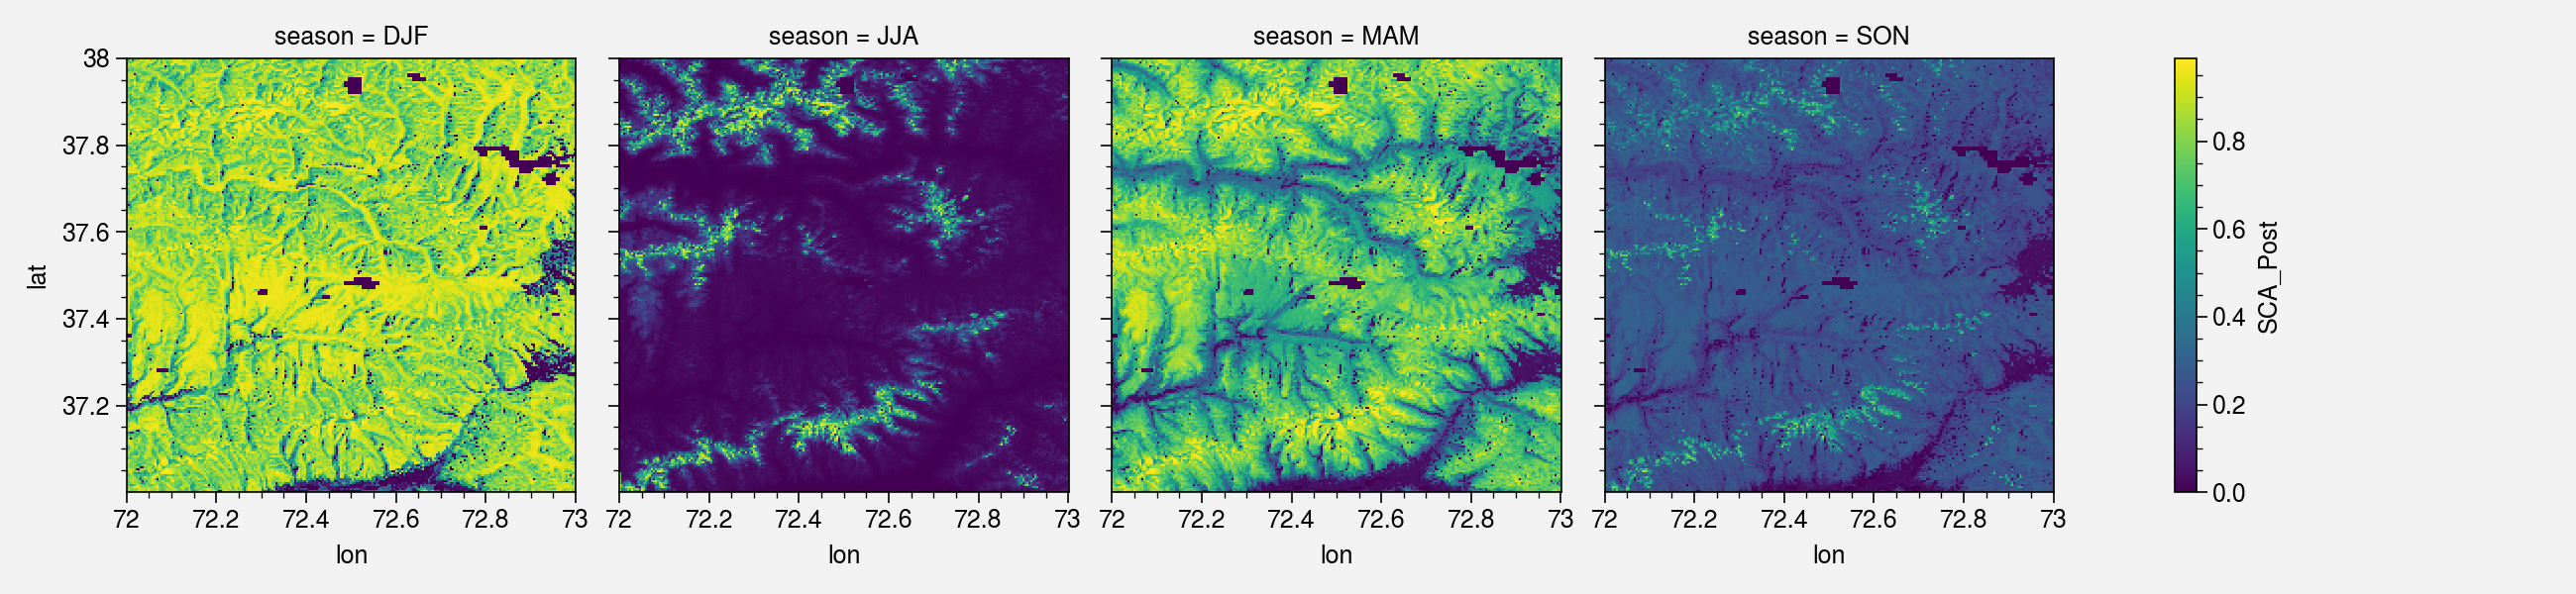

In [6]:
scf.groupby('time.season').mean('time').plot(col='season')

In [7]:
def get_divisors(n):
    for i in range(1, int(n / 2) + 1):
        if n % i == 0:
            yield i
    yield n

In [8]:
for i in get_divisors(225):
    print(i)

1
3
5
9
15
25
45
75
225


In [9]:
scf_15 = scf.coarsen(lat=15, lon=15).mean()
scf_25 = scf.coarsen(lat=25, lon=25).mean()
scf_45 = scf.coarsen(lat=45, lon=45).mean()
scf_75 = scf.coarsen(lat=75, lon=75).mean()

In [13]:
1/9

0.1111111111111111

In [11]:
1/3

0.3333333333333333

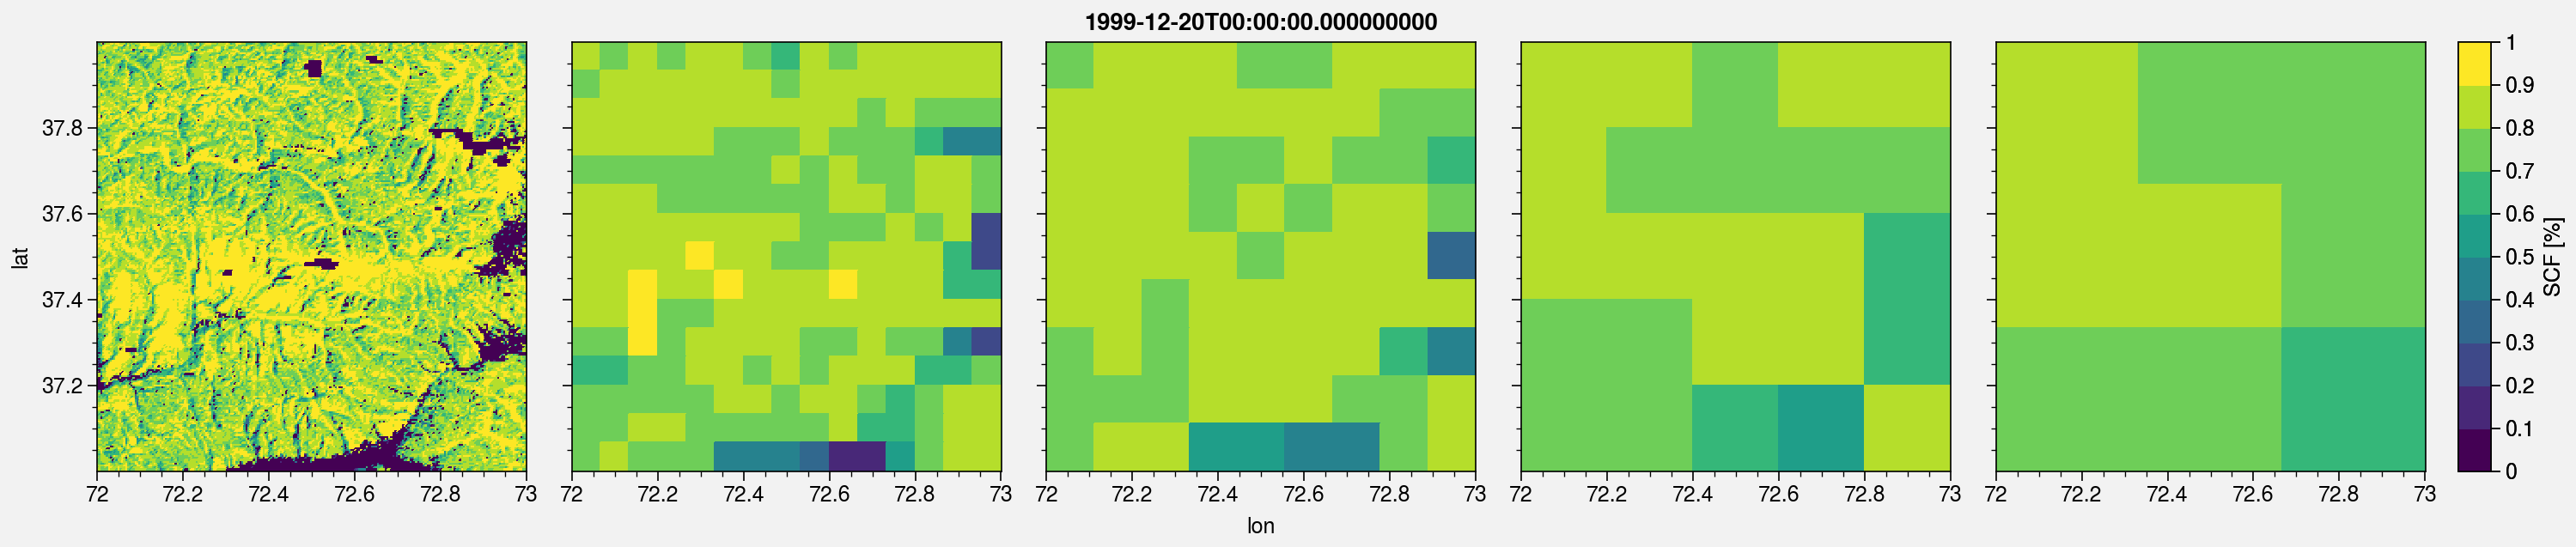

In [10]:
fig, axs = plot.subplots(ncols=5, nrows=1)

i_time = 80

for ax, scf_0 in zip(axs, [scf[i_time], scf_15[i_time], scf_25[i_time], scf_45[i_time], scf_75[i_time]]):
    m = ax.pcolormesh(scf_0, cmap='viridis', levels=plot.arange(0, 1, 0.1))
    
fig.colorbar(m, loc='r', label='SCF [%]')

axs.format(suptitle=scf[i_time].time.values)

## Check precip

In [46]:
ds = xr.open_dataset(path+'HMA_SR_D_v01_N37_0E72_0_agg_16_WY1999_00_FORCING_POST.nc')
ds

<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225)
Coordinates:
  * Latitude   (Latitude) float32 37.997776 37.993332 ... 37.006737 37.002293
  * Longitude  (Longitude) float32 72.00222 72.00667 ... 72.99411 72.99856
Dimensions without coordinates: Day
Data variables:
    Ta_Post    (Day, Longitude, Latitude) float32 ...
    Rs_Post    (Day, Longitude, Latitude) float32 ...
    Rl_Post    (Day, Longitude, Latitude) float32 ...
    Ps_Post    (Day, Longitude, Latitude) float32 ...
    PPT_Post   (Day, Longitude, Latitude) float32 ...
    q_Post     (Day, Longitude, Latitude) float32 ...

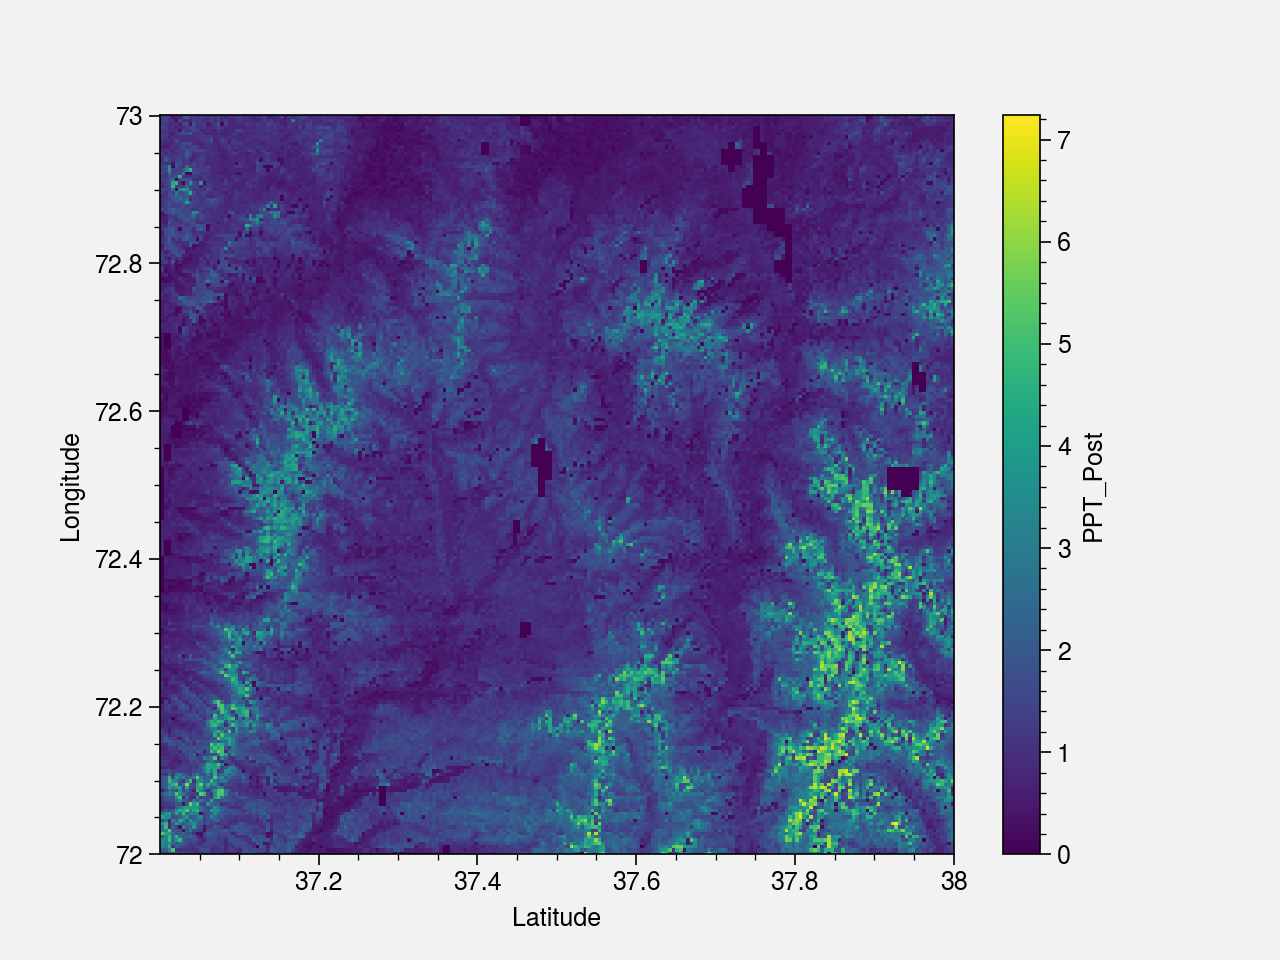

In [49]:
ds.PPT_Post.mean('Day').plot()

## Check snow depth

In [50]:
ds = xr.open_dataset(path+'HMA_SR_D_v01_N37_0E72_0_agg_16_WY1999_00_SD_POST.nc')
ds

<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225, Stats: 5)
Coordinates:
  * Latitude   (Latitude) float32 37.997776 37.993332 ... 37.006737 37.002293
  * Longitude  (Longitude) float32 72.00222 72.00667 ... 72.99411 72.99856
Dimensions without coordinates: Day, Stats
Data variables:
    SD_Post    (Day, Stats, Longitude, Latitude) float32 ...

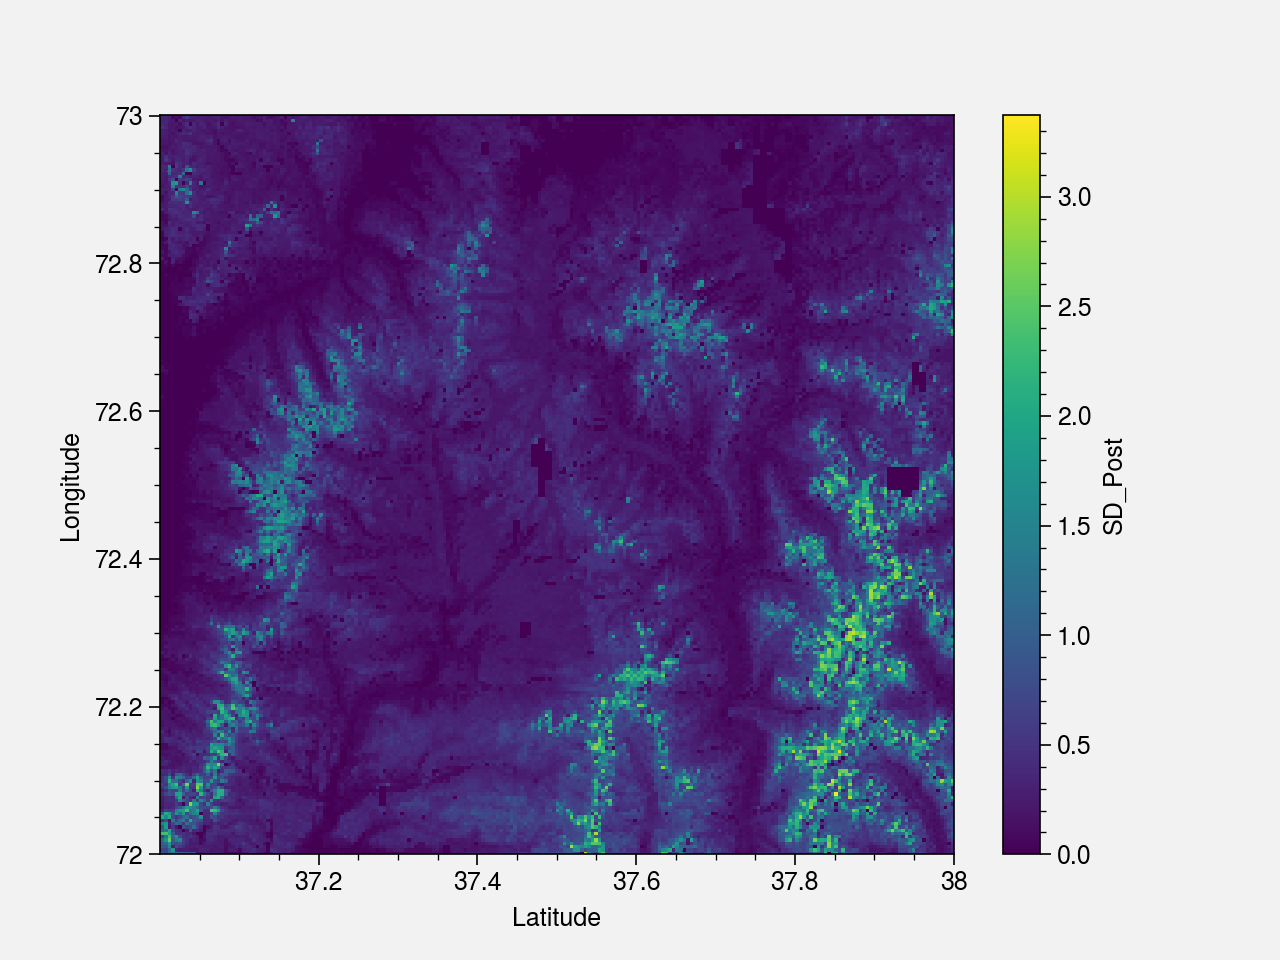

In [53]:
ds.SD_Post.isel(Stats=0).mean('Day').plot()